In [26]:
import os
import numpy as np
from numpy.random.mtrand import np

import warnings
warnings.filterwarnings("ignore")

# 使用原生pandas
import pandas as pd
from pandas.core.frame import DataFrame
# 使用modin
# import modin.pandas aspd
# import modin.config as cfg
# cfg.StorageFormat.put('hdk')
from fancyimpute import KNN
import missingno as msno
from fancyimpute import KNN 
import joblib

# %pip install xgboost
import xgboost
from xgboost.sklearn import XGBClassifier

# %pip install imblearn
from imblearn.combine import SMOTEENN
from sklearn.preprocessing._encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, preprocessing, metrics
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.linear_model as sk
from sklearn.metrics import recall_score,precision_score,roc_curve,roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection._split import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier 

from sklearnex import patch_sklearn
patch_sklearn()

import seaborn as sns

warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [27]:
# 使用modin
import modin.pandas as pd

import modin.config as cfg
cfg.StorageFormat.put('hdk')

In [28]:
# 以下两行导入Intel® Extension for Scikit-learn库，调用patch函数加速。如果使用原生的scikit-learn, 注释这两行即可
from sklearnex import patch_sklearn
patch_sklearn()

### 对内容进行初步分析 

In [29]:
#     df = pd.read_csv("dataset.csv", nrows=50000).drop_duplicates()
df = pd.read_csv("dataset.csv", skiprows=lambda x: x %  50 != 0).drop_duplicates()
# df = pd.read_csv("dataset.csv").drop_duplicates()

In [30]:
datas = df.drop_duplicates()
datas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119136 entries, 0 to 119135
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Index                   119136 non-null  int64  
 1   pH                      116773 non-null  float64
 2   Iron                    118348 non-null  float64
 3   Nitrate                 117015 non-null  float64
 4   Chloride                115582 non-null  float64
 5   Lead                    118600 non-null  float64
 6   Zinc                    116043 non-null  float64
 7   Color                   119005 non-null  object 
 8   Turbidity               118110 non-null  float64
 9   Fluoride                115242 non-null  float64
 10  Copper                  115110 non-null  float64
 11  Odor                    115630 non-null  float64
 12  Sulfate                 115167 non-null  float64
 13  Conductivity            115816 non-null  float64
 14  Chlorine            

In [31]:
# 将Index设置成索引列
datas.set_index("Index", inplace=True)

['Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity', 'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Water Temperature', 'Air Temperature', 'Day', 'Time of Day']
                            Iron   Nitrate  Chloride      Lead      Zinc  \
Iron                    1.000000  0.052264  0.057762  0.015840  0.029457   
Nitrate                 0.052264  1.000000  0.063189  0.008103  0.025856   
Chloride                0.057762  0.063189  1.000000  0.010162  0.028167   
Lead                    0.015840  0.008103  0.010162  1.000000 -0.000195   
Zinc                    0.029457  0.025856  0.028167 -0.000195  1.000000   
Turbidity               0.073656  0.071193  0.083104  0.012169  0.034060   
Fluoride                0.049904  0.053718  0.062160  0.013387  0.022785   
Copper                  0.067254  0.065472  0.079818  0.013185  0.032084   
Odor                    0.048985  0.050522  0.059942  0.013641  0.022012   
Sulfate  

<AxesSubplot:>

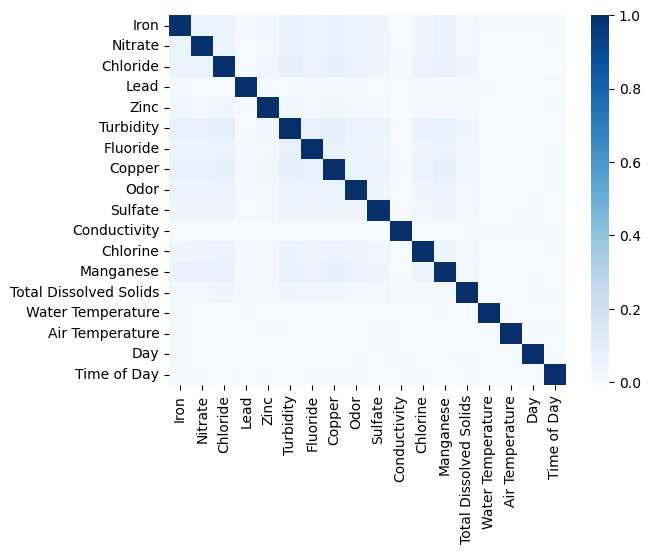

In [32]:
# 数值变量
num_variables = [v for v in datas.columns.tolist() if datas[v].dtype != "object"][1:-1]
print(num_variables)
df_num_value = datas[num_variables]
# 计算相关系数
print(df_num_value.corr())
sns.heatmap(df_num_value.corr(), cmap='Blues')

In [33]:
print(datas["Target"].value_counts())
print("target为0的占比：", datas["Target"].value_counts()[0] / (datas["Target"].value_counts()[0] + datas["Target"].value_counts()[1]))
print("target为0的占比：", datas["Target"].value_counts()[1] / (datas["Target"].value_counts()[0] + datas["Target"].value_counts()[1]))

0    83030
1    36106
Name: Target, dtype: int64
target为0的占比： 0.6969345957561106
target为0的占比： 0.30306540424388934


### 缺失数据处理

In [34]:
total = datas.isnull().sum().sort_values(ascending=False) 
percent = (datas.isnull().sum() / datas.isnull().count()).sort_values(ascending=False) 
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) 
missing_data.head(20) 

,Total,Percent
Copper,4026,0.033793
Sulfate,3969,0.033315
Fluoride,3894,0.032685
Chloride,3554,0.029831
Odor,3506,0.029429
Water Temperature,3353,0.028144
Conductivity,3320,0.027867
Zinc,3093,0.025962
pH,2363,0.019834
Time of Day,2302,0.019322


In [35]:
# 无效矩阵的数据密集显示
# msno.matrix(df_transferred) 

<AxesSubplot:>

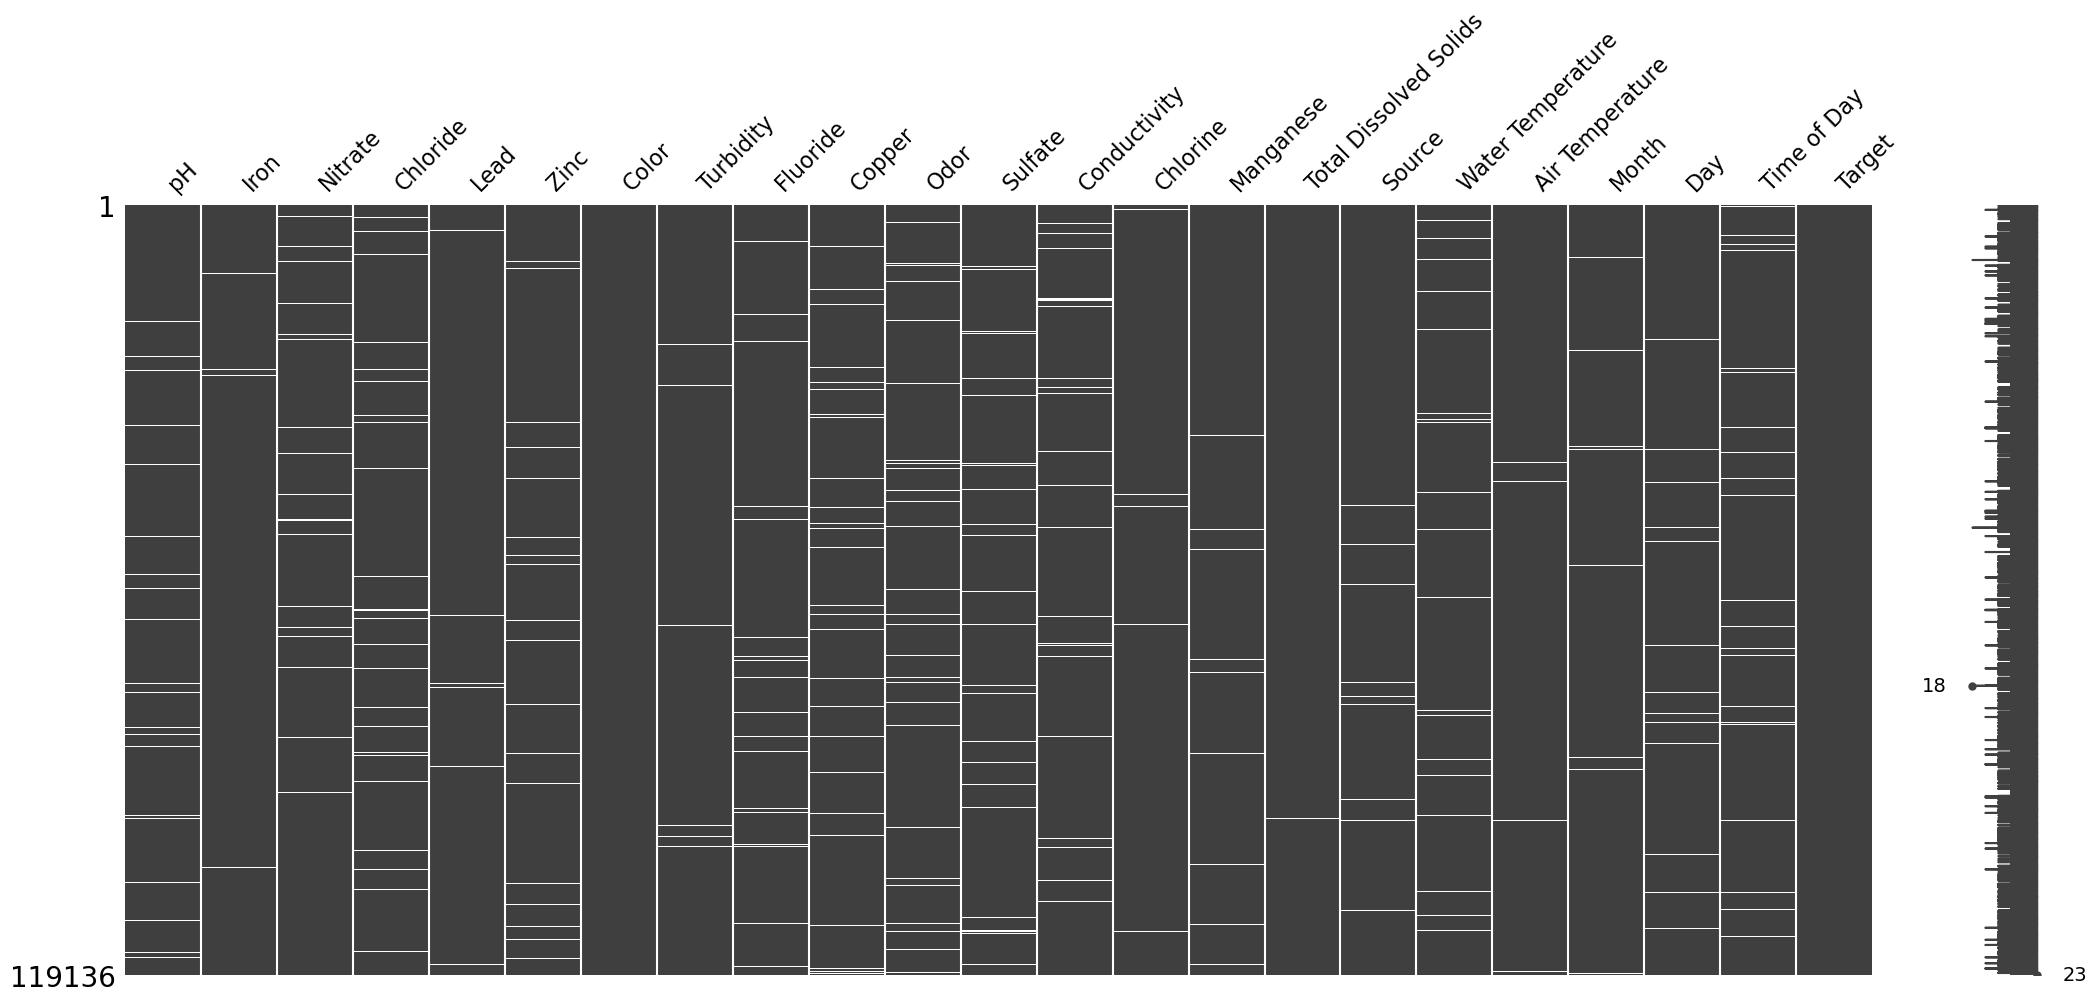

In [36]:
msno.matrix(datas) 

<AxesSubplot:>

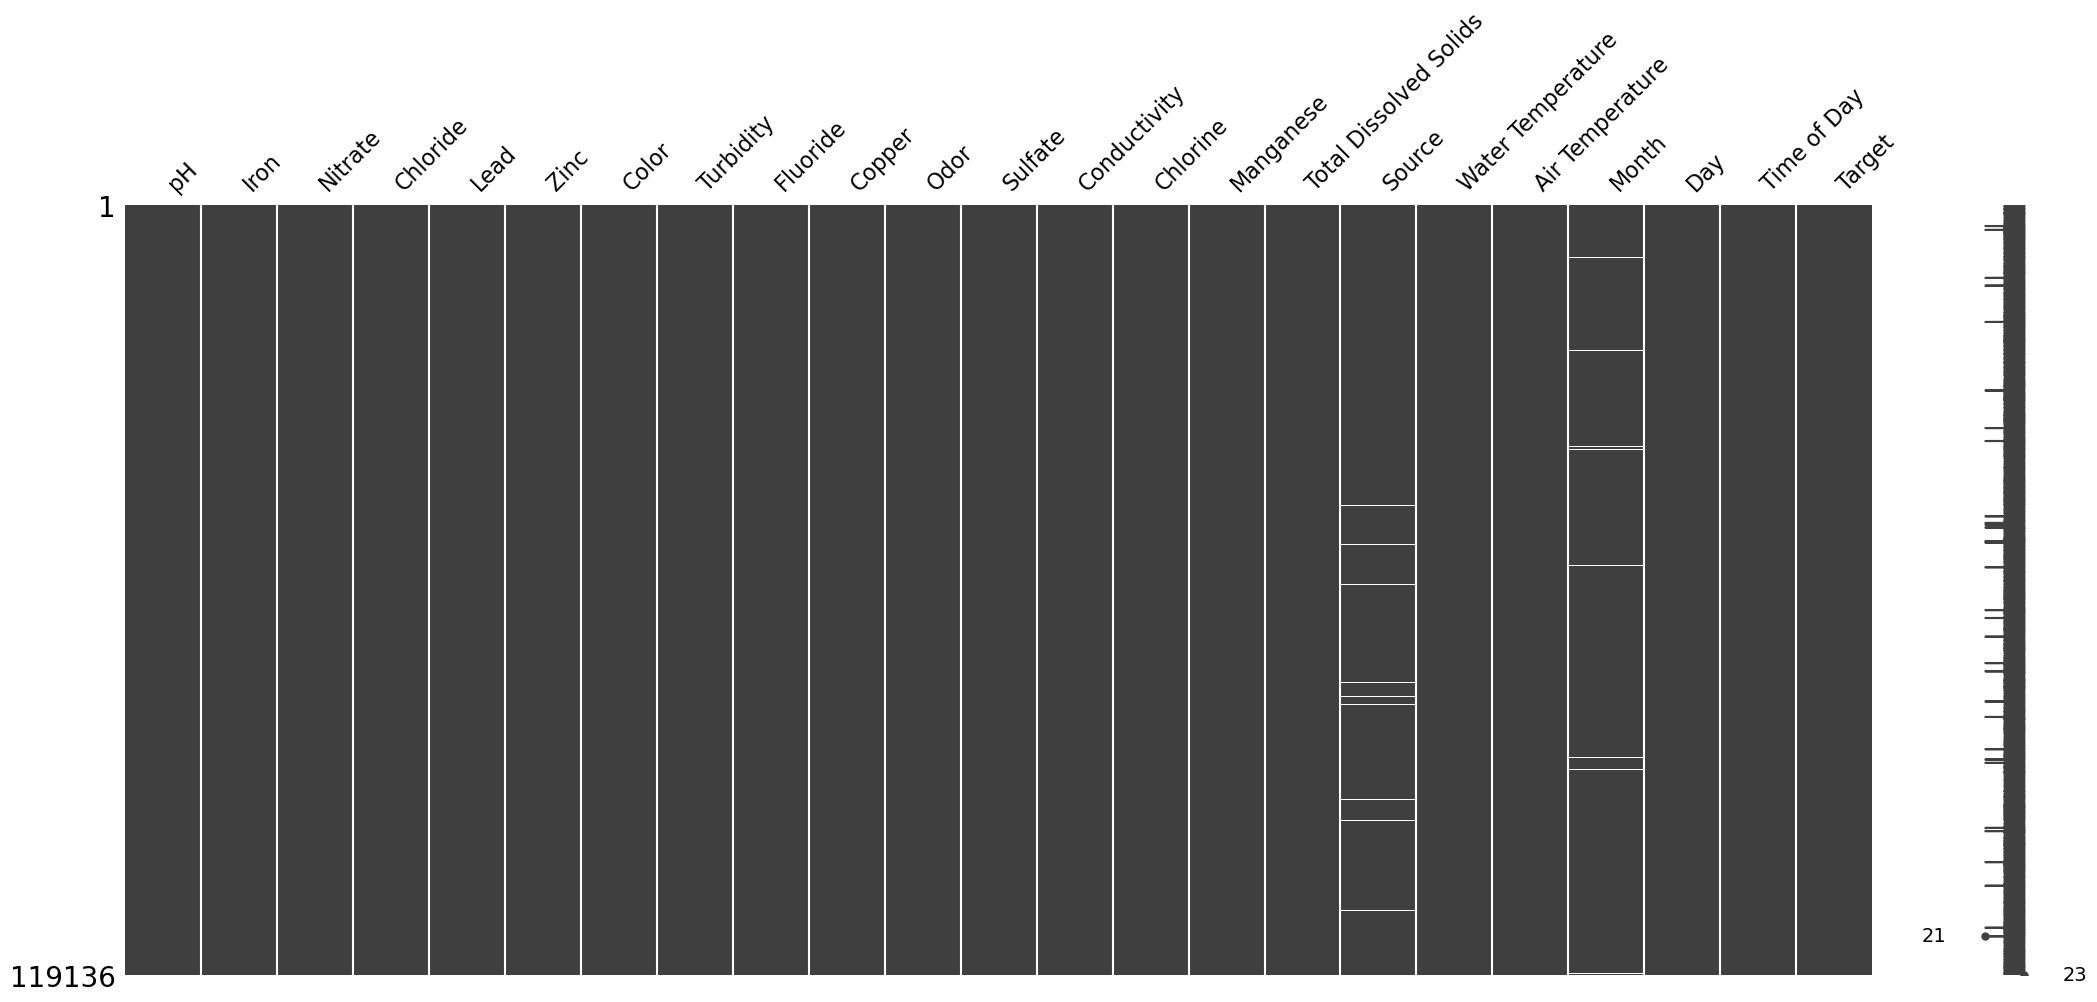

In [37]:
# 对于数值类型的数据 
num_variables = [v for v in datas.columns.tolist() if datas[v].dtype != "object"]
# 均值填充
datas[num_variables] = datas[num_variables].fillna(datas[num_variables].mean())
msno.matrix(datas) 

In [38]:
# num_variables = [v for v in datas.columns.tolist() if datas[v].dtype != "object"]
# # KNN填充 
# fill_knn = KNN(k=3).fit_transform(datas[num_variables])
# datas[num_variables] = pd.DataFrame(fill_knn)
# msno.matrix(datas) 

In [39]:
# 字符变量众数填充
str_variables = [v for v in datas.columns.tolist() if datas[v].dtype == "object"]
datas[str_variables] = datas[str_variables].fillna(datas[str_variables].mode())

In [40]:
# str_variables = [v for v in datas.columns.tolist() if datas[v].dtype == "object"]
# datas[str_variables] = datas[str_variables].fillna(df[str_variables].mode())
# msno.matrix(datas) 

### 数据类型转换 

In [41]:
print(datas["Color"].value_counts())
print(datas["Source"].value_counts())
print(datas["Month"].value_counts())

Colorless         35738
Near Colorless    35728
Faint Yellow      21456
Light Yellow      15219
Yellow            10864
Name: Color, dtype: int64
Reservoir    14816
Aquifer      14816
Stream       14751
Well         14660
Spring       14639
Lake         14635
River        14628
Ground       14489
Name: Source, dtype: int64
July         10053
March        10028
May          10021
August        9999
December      9994
October       9963
April         9864
January       9661
June          9561
September     9496
November      9434
February      9152
Name: Month, dtype: int64


In [42]:
datas["Color"].mode()[0]

'Colorless'

In [43]:
datas['Color'] = datas['Color'].map({"Colorless":0, "Near Colorless":1, "Faint Yellow":2, "Light Yellow":3,"Yellow":4})
# datas['Color'].fillna(method='backfill',inplace=True)

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [45]:
Source_1hot = pd.Series(datas['Source']) 
Source_1hot = pd.get_dummies(Source_1hot )
print(Source_1hot)

         Aquifer  Ground  Lake  Reservoir  River  Spring  Stream  Well
Index                                                                 
49             0       0     0          1      0       0       0     0
99             0       0     1          0      0       0       0     0
149            1       0     0          0      0       0       0     0
199            0       0     0          0      0       0       0     1
249            0       0     0          0      0       0       1     0
...          ...     ...   ...        ...    ...     ...     ...   ...
5956599        1       0     0          0      0       0       0     0
5956649        0       1     0          0      0       0       0     0
5956699        0       0     0          0      0       0       0     1
5956749        0       0     1          0      0       0       0     0
5956799        1       0     0          0      0       0       0     0

[119136 rows x 8 columns]


In [46]:
Month_1hot = pd.Series(datas['Month']) 
Month_1hot = pd.get_dummies(Month_1hot )
print(Month_1hot)

         April  August  December  February  January  July  June  March  May  \
Index                                                                         
49           0       1         0         0        0     0     0      0    0   
99           0       0         0         0        0     0     0      0    0   
149          0       0         0         0        0     0     0      1    0   
199          1       0         0         0        0     0     0      0    0   
249          1       0         0         0        0     0     0      0    0   
...        ...     ...       ...       ...      ...   ...   ...    ...  ...   
5956599      0       0         0         0        0     0     0      1    0   
5956649      0       0         0         0        0     0     0      0    0   
5956699      0       0         0         0        0     0     0      0    0   
5956749      0       0         0         1        0     0     0      0    0   
5956799      0       0         0         0        0 

In [47]:
Source_1hot = pd.Series(datas['Source']) 
dummies_Source = pd.get_dummies(Source_1hot)
Month_1hot = pd.Series(datas['Month']) 
dummies_Month = pd.get_dummies(Month_1hot)

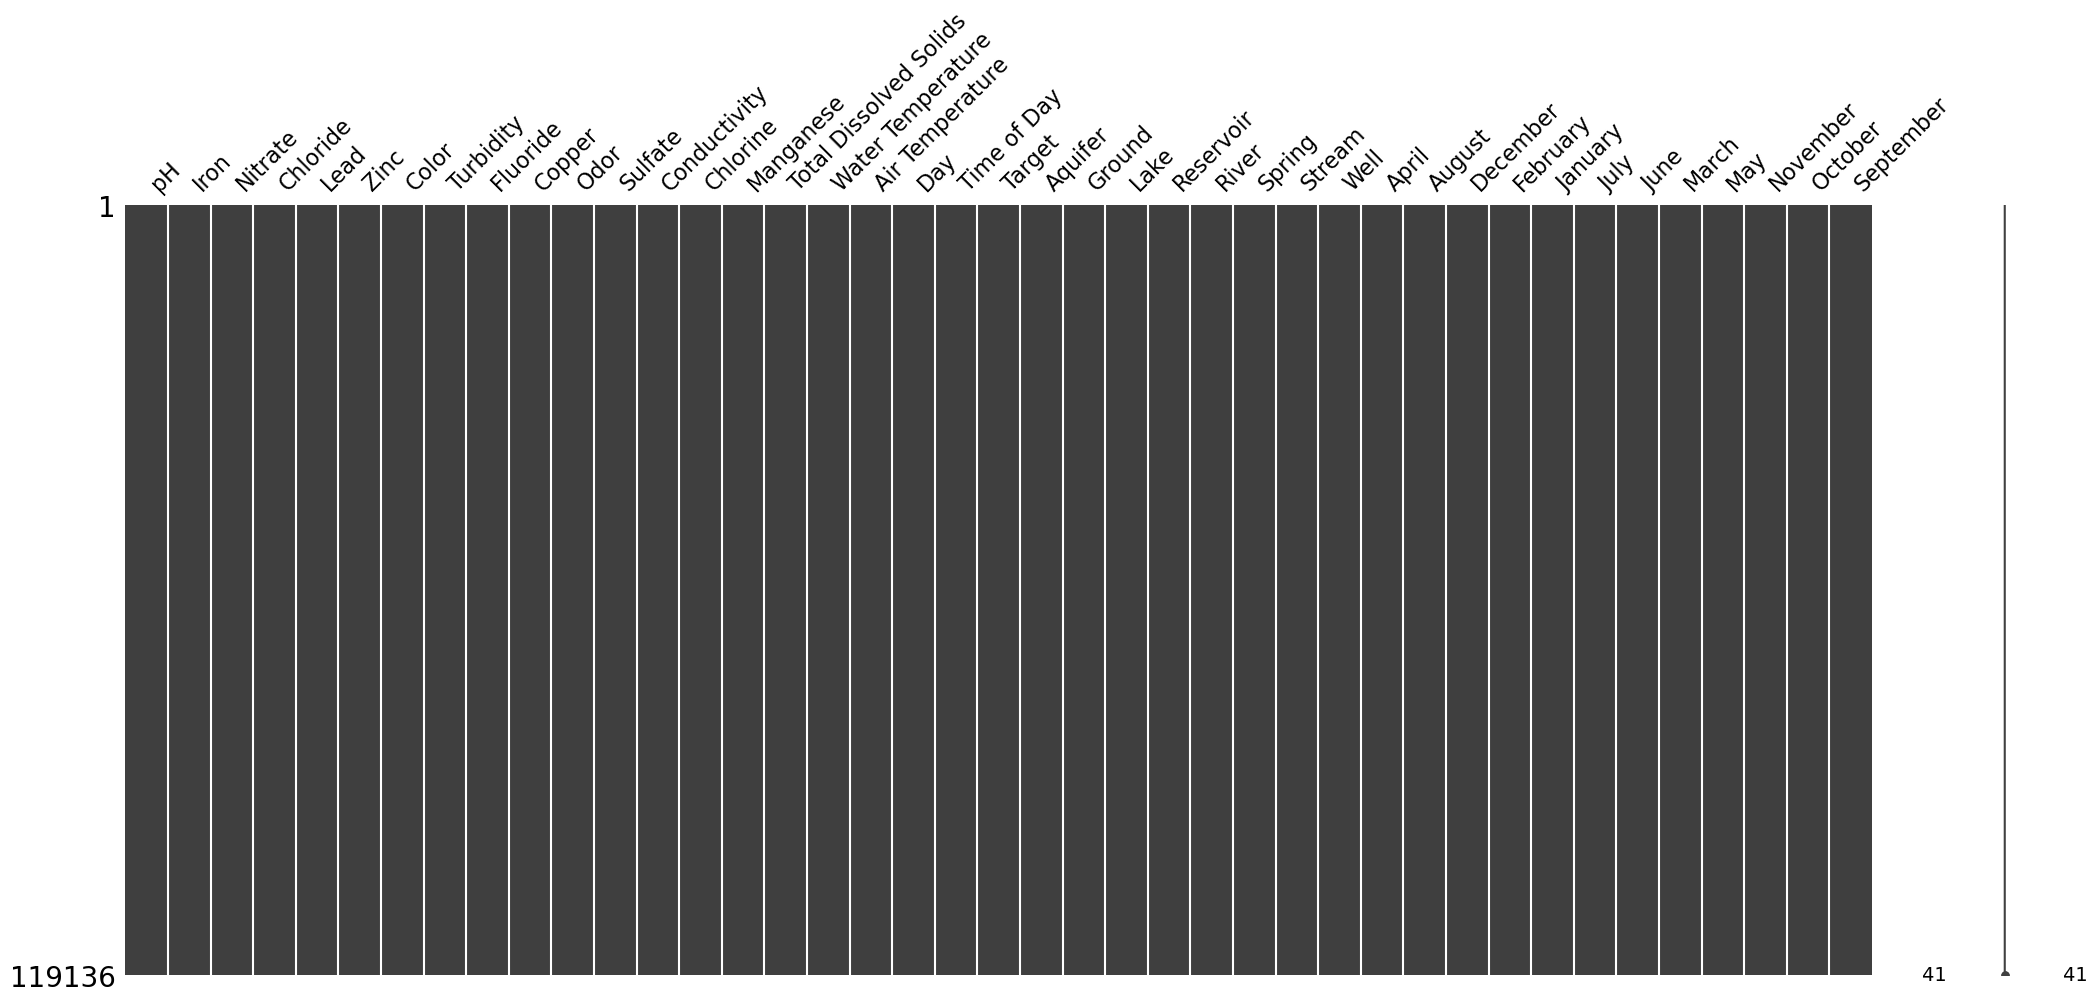

In [60]:
df_transferred = datas[["pH", "Iron","Nitrate","Chloride","Lead","Zinc","Color","Turbidity","Fluoride","Copper","Odor","Sulfate","Conductivity","Chlorine","Manganese","Total Dissolved Solids","Water Temperature",
                "Air Temperature","Day","Time of Day","Target"]].join(dummies_Source).join(dummies_Month)
df_transferred.head(5)

# msno.matrix(df_transferred) 
# datas['Color'].fillna(method='backfill',inplace=True)

df_transferred['Color'].fillna(method='ffill',inplace=True)
msno.matrix(df_transferred) 

# df_transferred.info()

df_transferred_X = df_transferred.drop("Target", axis=1)
X = df_transferred_X[df_transferred_X.columns.tolist()[:-1]]
y = df_transferred["Target"].tolist()

### 错误数据处理 

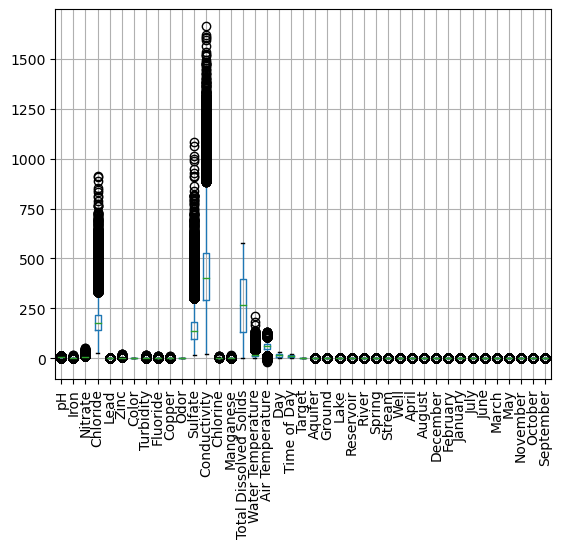

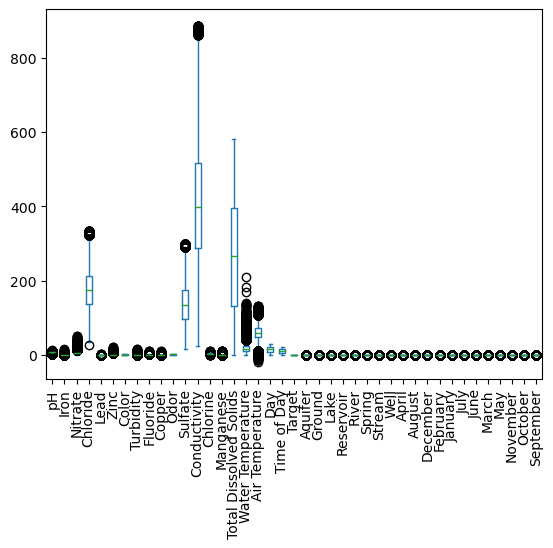

In [24]:
# 数值变量  
num_variables = [v for v in df_transferred.columns.tolist() if df_transferred[v].dtype != "object"]
df_transferred[num_variables].boxplot()
plt.xticks(rotation=90) 
plt.show()

for item in ["Chloride", "Sulfate", "Conductivity"]:       
#     for item in [4, 12, 13]:       
    q1 = df_transferred[item].quantile(0.25)
    q3 = df_transferred[item].quantile(0.75)
    iqr = q3 - q1
    df_transferred = df_transferred.query(f"(@q1 - 1.5 * @iqr) <= {item} <= (@q3 + 1.5 * @iqr)")
df_transferred.plot.box()
plt.xticks(rotation=90) 
plt.show()

### 重要特征筛选 

In [49]:
features = ["pH","Iron","Nitrate","Chloride","Lead","Zinc","Color","Turbidity","Fluoride","Copper",
           "Odor","Sulfate","Conductivity","Chlorine","Manganese","Total Dissolved Solids","Water Temperature","Air Temperature","Day","Time of Day","Aquifer","Ground","Lake","Reservoir",
           "River","Spring","Stream","Well","April","August","December","February","January","July",
           "June","March","May","November","October","September"]
A1 = df_transferred[features]
B1 = df_transferred[["Target"]]
x1 = A1.values
y1 = B1.values
print(x1)
print(y1)

[[6.54645709e+00 2.54620433e-02 8.35567728e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.11271042e+00 8.34398264e-03 4.87783860e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [7.56346734e+00 1.18776873e-01 3.94981401e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.80785913e+00 6.62432601e-08 1.05310320e+01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.94640991e+00 5.03265922e-17 8.96371102e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.23410164e+00 5.61432981e-02 9.49639012e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


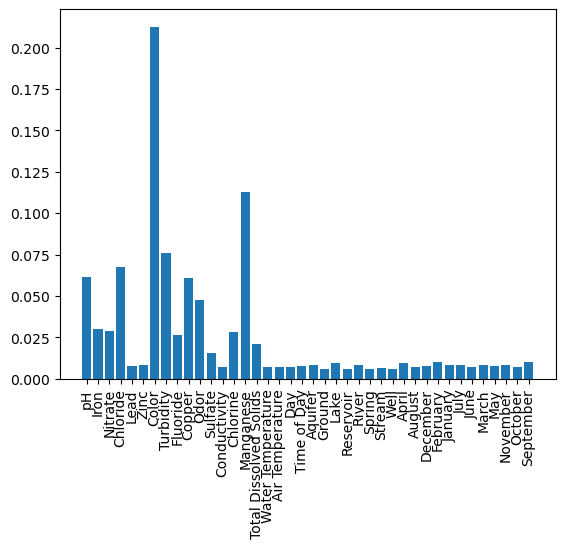

In [50]:
y1 = LabelEncoder().fit_transform(y1.ravel())
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=1)
xgboost = XGBClassifier()
xgboost.fit(x_train, y_train)
# print(list(xgboost.feature_importances_))

plt.bar(features, list(xgboost.feature_importances_)) 
plt.xticks(rotation=90) 
plt.show()

#### 效果不太明显，换个方式试下(在先前数据量选取较小时)

In [51]:
features = ["pH","Iron","Nitrate","Chloride","Lead","Zinc","Color","Turbidity","Fluoride","Copper",
           "Odor","Sulfate","Conductivity","Chlorine","Manganese","Total Dissolved Solids","Water Temperature","Air Temperature","Day","Time of Day","Aquifer","Ground","Lake","Reservoir",
           "River","Spring","Stream","Well","April","August","December","February","January","July",
           "June","March","May","November","October","September"]
A1 = df_transferred[features]
B1 = df_transferred[["Target"]]
x1 = A1.values
y1 = B1.values
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=1)

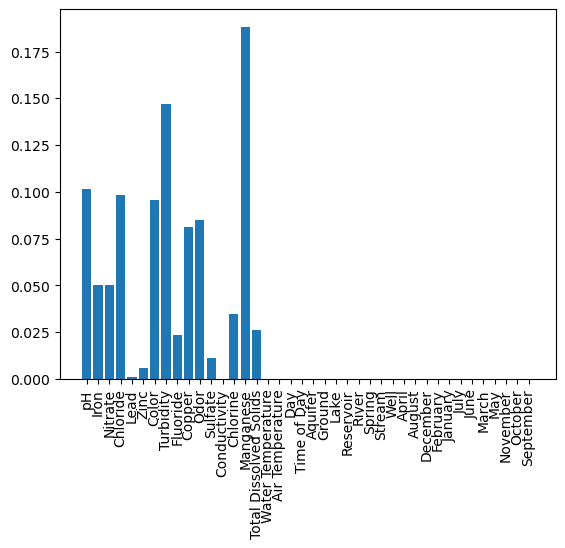

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3)
rf.fit(x_train, y_train)
# print(f"变量重要性{rf.feature_importances_}")

plt.bar(features, list(rf.feature_importances_)) 
plt.xticks(rotation=90) 
plt.show()

In [53]:
print(f"变量重要性{rf.feature_importances_}")

变量重要性[1.01710794e-01 5.00942313e-02 5.03670375e-02 9.85015232e-02
 1.03490934e-03 6.01937637e-03 9.54379344e-02 1.46857095e-01
 2.32309710e-02 8.11005586e-02 8.50314967e-02 1.10961936e-02
 1.92839580e-04 3.45841241e-02 1.88161162e-01 2.60002818e-02
 7.23182709e-05 1.96590616e-04 8.88862502e-05 6.47611934e-05
 8.85507151e-06 0.00000000e+00 6.66740081e-06 0.00000000e+00
 5.68554482e-06 8.75881686e-06 1.27532685e-05 3.60454330e-06
 3.86860091e-06 9.92538941e-06 1.72429966e-06 1.52299052e-05
 1.00948977e-05 0.00000000e+00 7.57156311e-06 0.00000000e+00
 1.10469230e-05 0.00000000e+00 2.86801201e-05 2.24497108e-05]


import matplotlib.pyplot as plt
plt.bar(train_x.columns.tolist()[1:-1], rf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

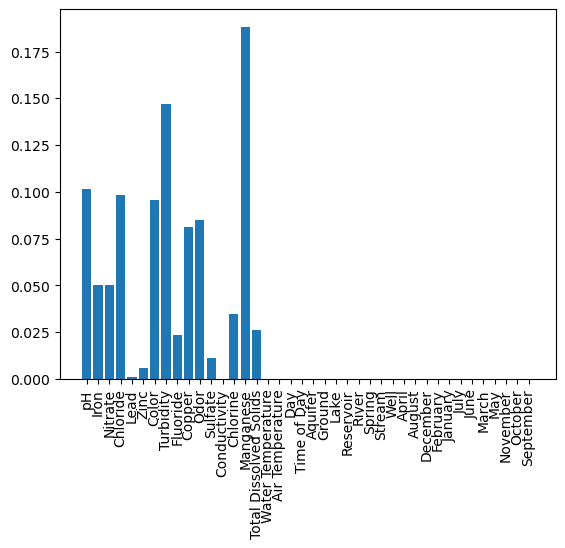

In [54]:
plt.bar(features, list(rf.feature_importances_)) 
plt.xticks(rotation=90) 
plt.show()

#### 因此，与结果相关性较大的特征为
- ["pH","Iron","Nitrate","Chloride","Color","Turbidity","Fluoride","Copper","Odor","Sulfate"," Chlorine","Manganese","Total Dissolved Solids" ]

##### 记录经过处理后的完整数据集和筛选后的数据集

In [55]:
# 保留完整的数据集 
A_a, A2_a, B_a, B2_a = train_test_split(df_transferred[["pH","Iron","Nitrate","Chloride","Lead","Zinc","Color","Turbidity","Fluoride","Copper",
       "Odor","Sulfate","Conductivity","Chlorine","Manganese","Total Dissolved Solids","Water Temperature","Air Temperature","Day",
        "Time of Day","Aquifer","Ground","Lake","Reservoir","River","Spring","Stream","Well","April","August","December","February",
        "January","July","June","March","May","November","October","September"]],df[["Target"]], test_size=0.3)
X_train_a = A_a.values
X_test_a = A2_a.values
y_train_a = B_a.values
y_test_a = B2_a.values

In [56]:
# 仅保留相关性强的特征的数据集 (selected)
A_s, A2_s, B_s, B2_s = train_test_split(df_transferred[["pH","Iron","Nitrate","Chloride","Color","Turbidity","Fluoride","Copper","Odor","Sulfate","Chlorine","Manganese","Total Dissolved Solids" ]],df[["Target"]], test_size=0.4)
X_train_s = A_s.values
X_test_s = A2_s.values
y_train_s = B_s.values
y_test_s = B2_s.values

### 数据平衡 
- 完整数据集

In [57]:
# 保留完整的数据集 
A_a, A2_a, B_a, B2_a = train_test_split(df_transferred[["pH","Iron","Nitrate","Chloride","Lead","Zinc","Color","Turbidity","Fluoride","Copper",
       "Odor","Sulfate","Conductivity","Chlorine","Manganese","Total Dissolved Solids","Water Temperature","Air Temperature","Day",
        "Time of Day","Aquifer","Ground","Lake","Reservoir","River","Spring","Stream","Well","April","August","December","February",
        "January","July","June","March","May","November","October","September"]],df[["Target"]], test_size=0.3)
X_train_a = A_a.values
X_test_a = A2_a.values
y_train_a = B_a.values
y_test_a = B2_a.values

In [58]:
print(" #### BEFORE: 训练集数据平衡性 ####")
print(y_train_a.tolist().count(0.0) / (y_train_a.shape[0]))

print(" #### AFTER: 训练集数据平衡性 ####")
X_train_a, y_train_a = SMOTEENN(random_state=42).fit_resample(X_train_a, y_train_a)
### AFTER: 训练集数据平衡性 ####
print(y_train_a.tolist().count(0.0) / (y_train_a.shape[0]))

# 测试集数据也可以平衡一下
print(" #### BEFORE: 训练集数据平衡性 ####")
print(y_test_a.tolist().count(0.0)/ (y_test_a.shape[0]))

print(" #### AFTER: 测试集数据平衡性 ####")
X_train_a, y_train_a = SMOTEENN(random_state=42).fit_resample(X_train_a, y_train_a)
### AFTER: 训练集数据平衡性 ####
print(y_test_a.tolist().count(0.0) / (y_test_a.shape[0]))

 #### BEFORE: 训练集数据平衡性 ####
0.0
 #### AFTER: 训练集数据平衡性 ####
0.3743165924984107
 #### BEFORE: 训练集数据平衡性 ####
0.0
 #### AFTER: 测试集数据平衡性 ####
0.0


- 仅重要特征数据集

In [61]:
# 仅保留相关性强的特征的数据集 (selected)
A_s, A2_s, B_s, B2_s = train_test_split(df_transferred[["pH","Iron","Nitrate","Chloride","Color","Turbidity","Fluoride","Copper","Odor","Sulfate","Chlorine","Manganese","Total Dissolved Solids" ]],df[["Target"]], test_size=0.4)
X_train_s = A_s.values
X_test_s = A2_s.values
y_train_s = B_s.values
y_test_s = B2_s.values

In [62]:
print(" #### BEFORE: 训练集数据平衡性 ####")
print(y_train_s.tolist().count(0.0) / (y_train_s.shape[0]))

print(" #### AFTER: 训练集数据平衡性 ####")
X_train_s, y_train_s = SMOTEENN(random_state=42).fit_resample(X_train_s, y_train_s)
### AFTER: 训练集数据平衡性 ####
print(y_train_s.tolist().count(0.0) / (y_train_s.shape[0]))

# 测试集数据也可以平衡一下
print(" #### BEFORE: 训练集数据平衡性 ####")
print(y_test_s.tolist().count(0.0)/ (y_test_s.shape[0]))

print(" #### AFTER: 测试集数据平衡性 ####")
X_train_s, y_train_s = SMOTEENN(random_state=42).fit_resample(X_train_a, y_train_a)
### AFTER: 训练集数据平衡性 ####
print(y_test_a.tolist().count(0.0) / (y_test_a.shape[0]))

 #### BEFORE: 训练集数据平衡性 ####
0.0
 #### AFTER: 训练集数据平衡性 ####
0.4567114155084792
 #### BEFORE: 训练集数据平衡性 ####
0.0
 #### AFTER: 测试集数据平衡性 ####
0.0


### 建模 + 训练 

In [63]:
# print(X_train, X_test, y_train, y_test)
# 随机森林分类器 
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=20)
rf.fit(X_train_a, y_train_a)
# 测试集预测 
y_hat = rf.predict(X_test_a)
# 模型评估 
print("Accuracy:",metrics.accuracy_score(y_test_a,y_hat))
print(metrics.classification_report(y_test_a,y_hat))

Accuracy: 0.879466159312834
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     24871
           1       0.73      0.97      0.83     10870

    accuracy                           0.88     35741
   macro avg       0.85      0.90      0.87     35741
weighted avg       0.90      0.88      0.88     35741



In [64]:
# # 模型持久化 
# joblib.dump(rf, 'randomForestClf.pkl')
# print(rf)

In [68]:
# # 只含重要特征的模型
# # 随机森林分类器 
# rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=20)
# rf.fit(X_train_s, y_train_s)
# # 测试集预测 
# y_hat_1 = rf.predict(X_test_s)
# # 模型评估 
# print("Accuracy:",metrics.accuracy_score(y_test_s,y_hat_1))
# # print(metrics.classification_report(y_test_a,y_hat_1))

#### 模型评估 

- 混淆矩阵

In [69]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test, y_hat)
print(cm1.shape) # (2, 2)
print(cm1)

(2, 2)
[[14819 10074]
 [ 6498  4350]]


(14819, 10074, 6498, 4350)


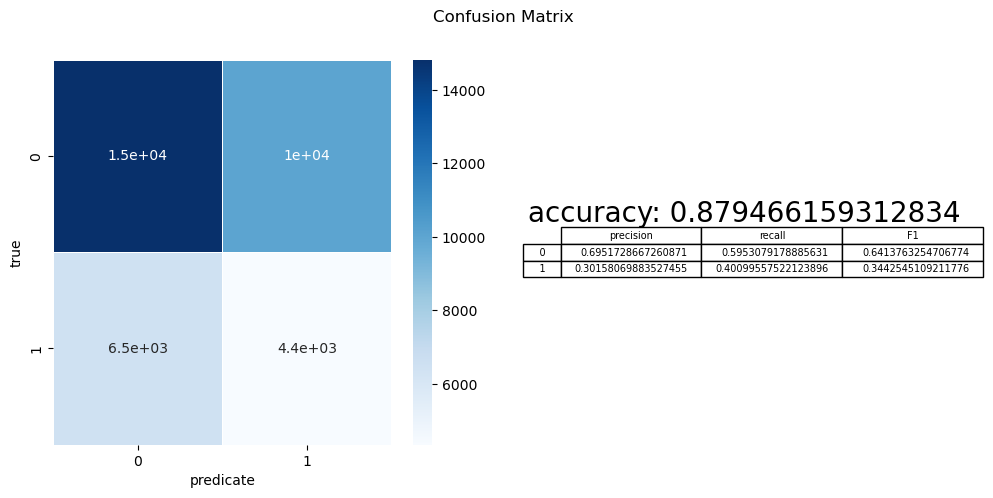

In [73]:
fig = plt.figure(figsize=(12,5))
fig.suptitle(r'Confusion Matrix')
#画热力图
ax1 = fig.add_subplot(1,2,1)
sns.heatmap(cm1,annot=True,cmap='Blues',linewidths=0.5,ax=ax1)
ax1.set_xlabel('predicate')
ax1.set_ylabel('true')

(tn,fp,fn,tp) = cm1.ravel()
print((tn,fp,fn,tp))

acc = metrics.accuracy_score(y_test_a,y_hat)
pre0 = tn/(fn+tn)
pre1 =tp/(tp+fp)
recall0 = tn/(fp+tn)
recall1 = tp/(tp+fn)
f10 = 2*tn/(2*tn+fp+fn)
f11 = 2*tp/(2*tp+fp+fn)

col_labels = ['precision','recall','F1']
row_labels = [' '*4+'0'+' '*4,' '*4+'1'+' '*4]
table_vals = [[pre0,recall0,f10],[pre1,recall1,f11]]
ax2 = fig.add_subplot(1,2,2)
ax2.table(cellText=table_vals,rowLabels=row_labels,
          colLabels=col_labels,loc='center')
ax2.text(0.35,0.6,
         r'''
        accuracy: {acc}
          '''.format(acc=acc),horizontalalignment='center',verticalalignment='center',fontsize=20, color='black',transform=ax2.transAxes)
ax2.axis('off')
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()   

- ROC/AUC

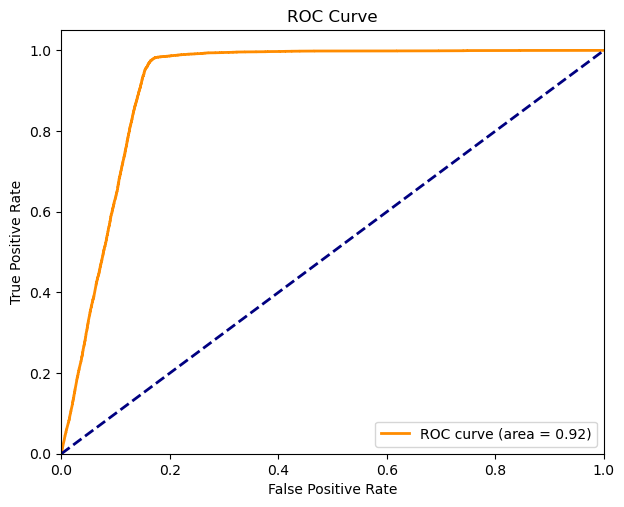

In [71]:
from sklearn.metrics import roc_curve
from sklearn import metrics

y_score = rf.fit(X_train_a, y_train_a).predict_proba(X_test_a)  # 随机森林
fpr, tpr, thresholds = roc_curve(y_test_a, y_score[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.subplots(figsize=(7, 5.5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
